In [1]:
import model, dataset
from importlib import reload

from torchinfo import summary
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import skimage

D:\Github\smlm-dl\smlm_dl\dataset.py:220: RuntimeWarning: divide by zero encountered in log
  im = axes[1].imshow(np.log(tiled_images))


125:	 [x = 5.509,], [y = -5.025,], [sig_x = 5.000,], [sig_y = 5.000,], [A = 948.547,], [bg = 80.187,],
98:	 [x = 3.225,], [y = 11.551,], [sig_x = 5.000,], [sig_y = 5.000,], [A = 1200.641,], [bg = 26.319,],
7:	 [x = 9.365,], [y = -7.972,], [sig_x = 5.000,], [sig_y = 5.000,], [A = 1891.458,], [bg = 91.928,],
72:	 [x = 10.737,], [y = -0.239,], [sig_x = 5.000,], [sig_y = 5.000,], [A = 1079.489,], [bg = 46.748,],
23:	 [x = -3.265,], [y = 5.663,], [sig_x = 5.000,], [sig_y = 5.000,], [A = 1755.920,], [bg = 86.779,],
113:	 [x = 5.120,], [y = -2.859,], [sig_x = 5.000,], [sig_y = 5.000,], [A = 620.670,], [bg = 17.084,],
46:	 [x = 0.602,], [y = 1.035,], [sig_x = 5.000,], [sig_y = 5.000,], [A = 1604.904,], [bg = 36.866,],
122:	 [x = -1.022,], [y = 0.943,], [sig_x = 5.000,], [sig_y = 5.000,], [A = 1217.145,], [bg = 12.785,],


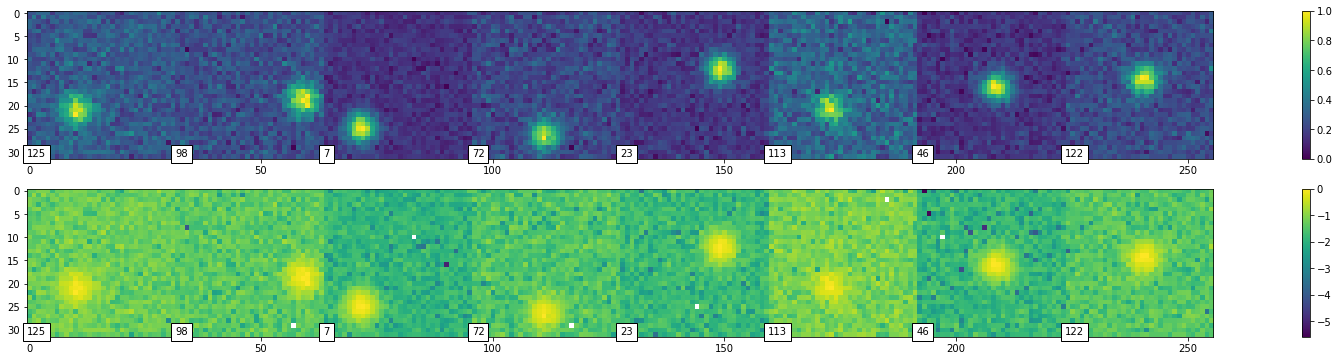

In [2]:
training_data = dataset.Gaussian2DPSFDataset(length=128, psf_zerns={4:0, 5:0.5, 7:1})
dataset.inspect_images(training_data)

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)

dd = next(iter(train_dataloader))

C:\Users\Kenny\anaconda3\envs\smlm-dl\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


Layer (type (var_name))                  Output Shape              Param #
EncoderModel                             --                        --
├─ModuleDict (encoders)                  --                        --
│    └─Sequential (conv_layer0)          [32, 16, 16, 16]          --
│    │    └─GroupNorm (0)                [32, 1, 32, 32]           2
│    │    └─Conv2d (1)                   [32, 16, 32, 32]          160
│    │    └─ReLU (2)                     [32, 16, 32, 32]          --
│    │    └─GroupNorm (3)                [32, 16, 32, 32]          32
│    │    └─Conv2d (4)                   [32, 16, 32, 32]          2,320
│    │    └─ReLU (5)                     [32, 16, 32, 32]          --
│    │    └─MaxPool2d (6)                [32, 16, 16, 16]          --
│    │    └─Dropout2d (7)                [32, 16, 16, 16]          --
│    └─Sequential (conv_layer1)          [32, 32, 8, 8]            --
│    │    └─GroupNorm (0)                [32, 16, 16, 16]          32
│    │    └─

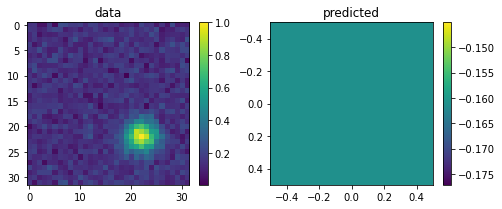

In [3]:
reload(model)
encoder_model = model.EncoderModel(img_size=(32,32),
                                   depth=4,
                                   first_layer_out_channels=16)
print(summary(encoder_model, input_size=(32, 1, 32, 32), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)

{'x': [<act: Tanh, offset: 0, scaling: 24.0, default: 0, per psf: True, >], 'y': [<act: Tanh, offset: 0, scaling: 24.0, default: 0, per psf: True, >], 'A': [<act: ReLU, offset: 0, scaling: 1000, default: 1, per psf: True, >], 'sig': [<act: ReLU, offset: 2, scaling: 1, default: 5, per psf: True, >], 'bg': [<act: Tanh, offset: 0, scaling: 500, default: 0, per psf: False, >]}
Layer (type (var_name))                       Output Shape              Param #
Gaussian2DModel                               --                        --
├─EncoderModel (encoder)                      [32, 5, 1, 1]             --
│    └─ModuleDict (skips)                     --                        --
│    │    └─Sequential (skip_conv_layer0)     [32, 4, 1, 1]             --
│    │    │    └─GroupNorm (0)                [32, 1, 32, 32]           2
│    │    │    └─Conv2d (1)                   [32, 4, 1, 1]             4,100
│    │    │    └─ReLU (2)                     [32, 4, 1, 1]             --
│    │    │    └─

D:\Github\smlm-dl\smlm_dl\model.py:648: RuntimeWarning: invalid value encountered in log10
  im = axes[0, i].imshow(np.log10(img[0]))


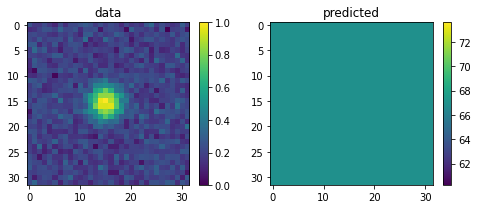

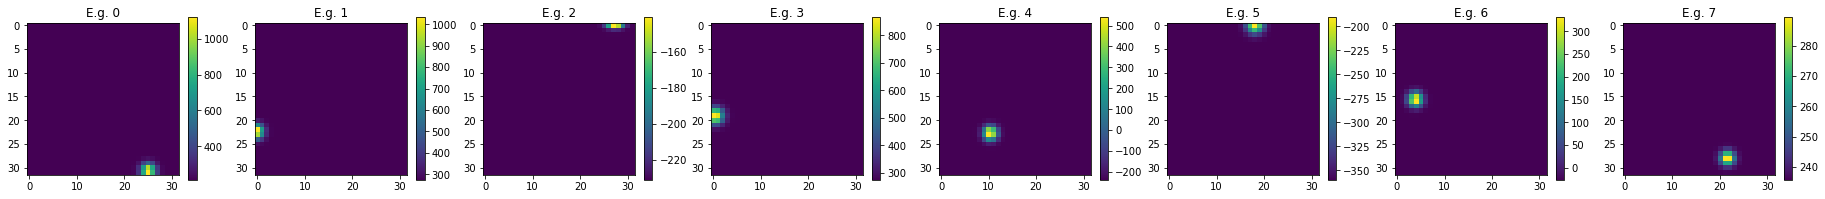

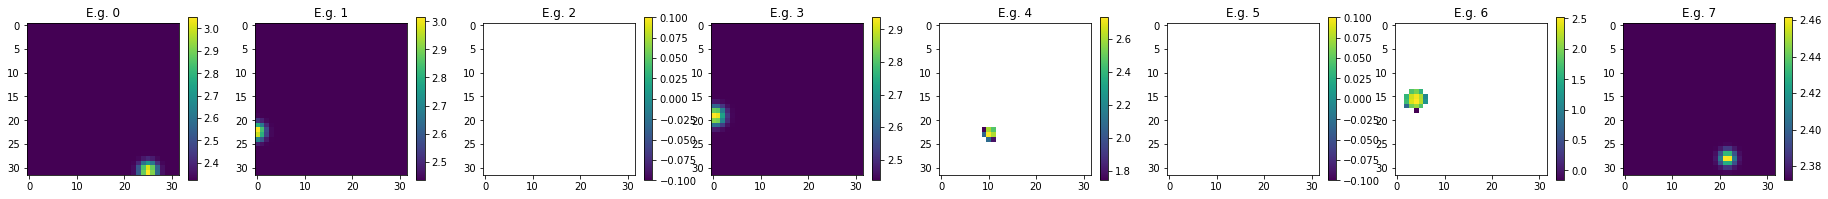

In [4]:
reload(model)

encoder_model = model.Gaussian2DModel(img_size=(32,32),
                                      fit_params=['x','y','A','sig','bg'],
                                      max_psf_count=1,
                                      encoder_params={"depth":3,
                                                      "skip_channels":4,
                                                      # "first_layer_out_channels":16,
                                                     })

print(encoder_model.fit_params)


print(summary(encoder_model, input_size=(32, 1, 32, 32), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)

Layer (type (var_name))                       Output Shape              Param #
Gaussian2DModel                               --                        --
├─EncoderModel (encoder)                      [32, 13, 1, 1]            --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [32, 16, 16, 16]          --
│    │    │    └─GroupNorm (0)                [32, 1, 32, 32]           2
│    │    │    └─Conv2d (1)                   [32, 16, 32, 32]          160
│    │    │    └─ReLU (2)                     [32, 16, 32, 32]          --
│    │    │    └─GroupNorm (3)                [32, 16, 32, 32]          32
│    │    │    └─Conv2d (4)                   [32, 16, 32, 32]          2,320
│    │    │    └─ReLU (5)                     [32, 16, 32, 32]          --
│    │    │    └─MaxPool2d (6)                [32, 16, 16, 16]          --
│    │    │    └─Dropout2d (7)                [32, 16, 16, 16]          --
│    │    └─Seque

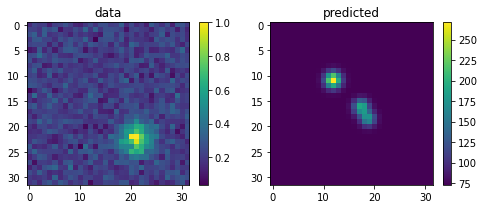

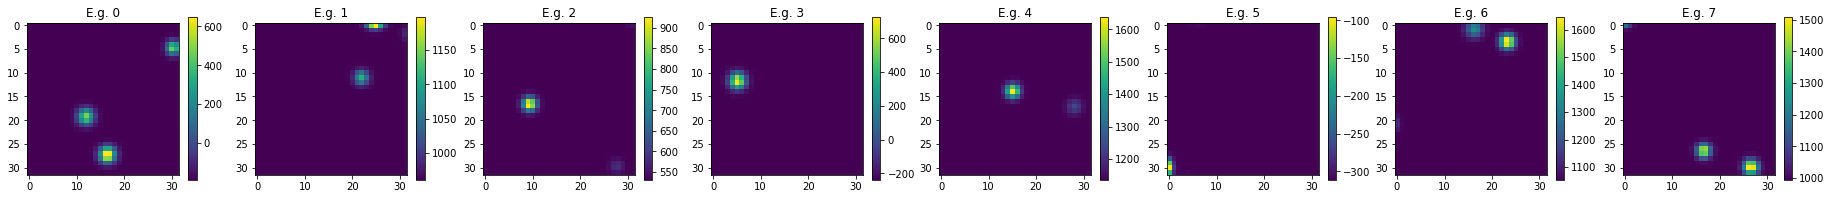

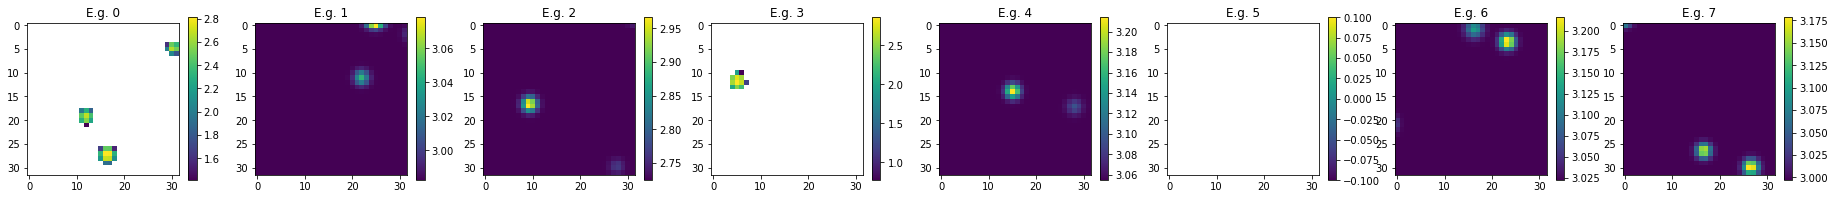

In [5]:
reload(model)

encoder_model = model.Gaussian2DModel(fit_params=['x','y','A','sig','bg'],
                                      max_psf_count=3,
                                      encoder_params={"depth":3, "first_layer_out_channels":16,},
                                      )
print(summary(encoder_model, input_size=(32, 1, 32, 32), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)

Layer (type (var_name))                       Output Shape              Param #
Template2DModel                               --                        --
├─EncoderModel (encoder)                      [32, 4, 1, 1]             --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [32, 16, 16, 16]          --
│    │    │    └─GroupNorm (0)                [32, 1, 32, 32]           2
│    │    │    └─Conv2d (1)                   [32, 16, 32, 32]          160
│    │    │    └─ReLU (2)                     [32, 16, 32, 32]          --
│    │    │    └─GroupNorm (3)                [32, 16, 32, 32]          32
│    │    │    └─Conv2d (4)                   [32, 16, 32, 32]          2,320
│    │    │    └─ReLU (5)                     [32, 16, 32, 32]          --
│    │    │    └─MaxPool2d (6)                [32, 16, 16, 16]          --
│    │    │    └─Dropout2d (7)                [32, 16, 16, 16]          --
│    │    └─Seque

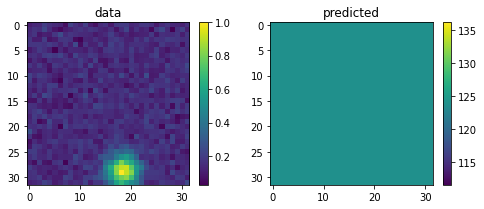

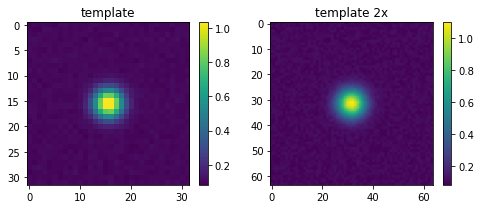

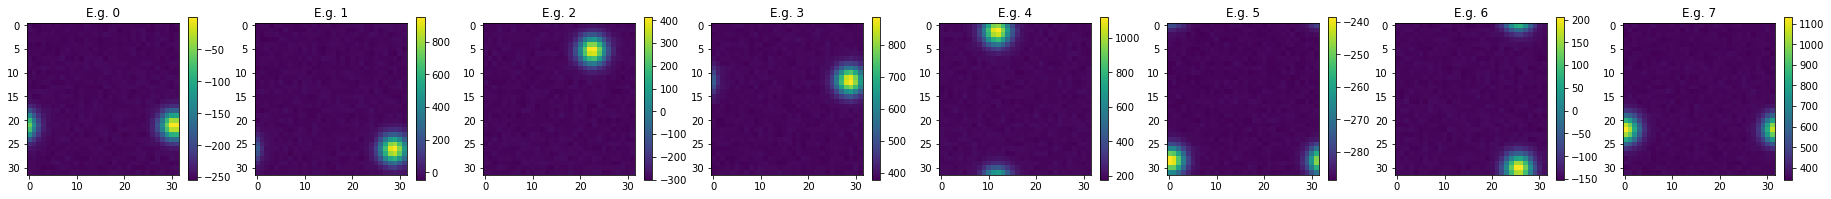

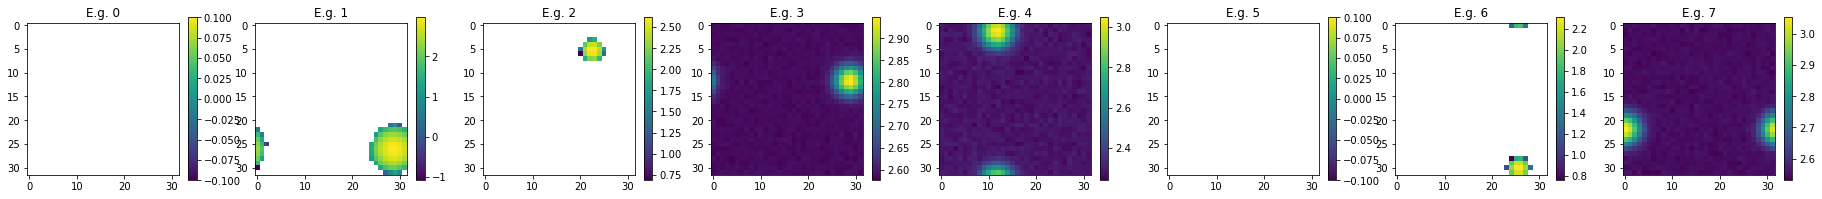

In [6]:
reload(model)

encoder_model = model.Template2DModel(fit_params=['x','y','A','bg'],
                                     )
print(summary(encoder_model, input_size=(32, 1, 32, 32), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)

Layer (type (var_name))                       Output Shape              Param #
Template2DModel                               --                        --
├─Template2DRenderer (renderer)               --                        --
│    └─Sequential (template)                  [64, 64]                  --
│    │    └─ParameterModule (0)               [64, 64]                  4,096
│    │    └─ReLU (1)                          [64, 64]                  --
│    └─AvgPool2d (template_pooling)           [1, 1, 32, 32]            --
├─DirectConcatFeedbackModel (feedbacker)      [32, 2, 32, 32]           --
│    └─GroupNorm (norm)                       [32, 1, 32, 32]           2
├─EncoderModel (encoder)                      [32, 4, 1, 1]             --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [32, 16, 16, 16]          --
│    │    │    └─GroupNorm (0)                [32, 2, 32, 32]           4
│    │    │    └─Co

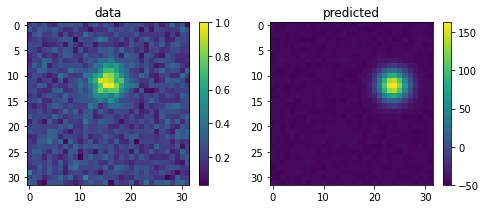

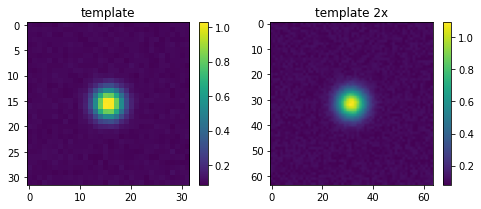

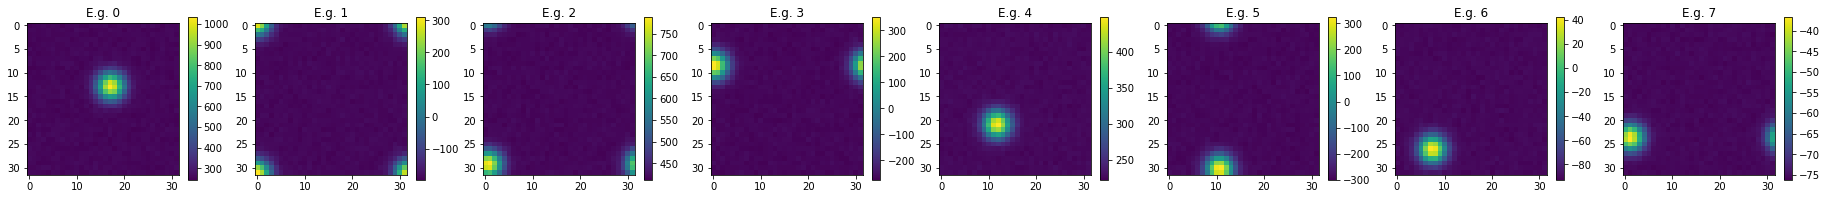

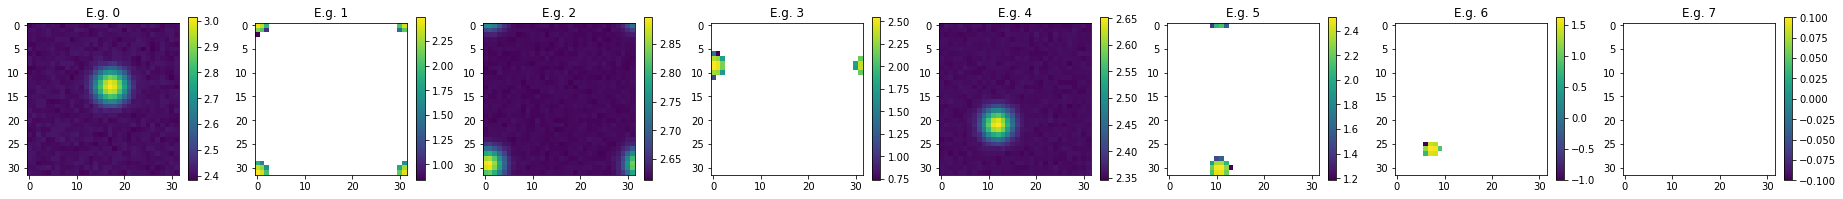

In [7]:
reload(model)

encoder_model = model.Template2DModel(feedback_class=model.DirectConcatFeedbackModel,
                                      fit_params=['x','y','A','bg'],
                                      encoder_params={"depth":3, "first_layer_out_channels":16,},
                                     )
print(summary(encoder_model, input_size=(32, 1, 32, 32), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)

Layer (type (var_name))                       Output Shape              Param #
Template2DModel                               --                        --
├─EncoderModel (encoder)                      [32, 10, 1, 1]            --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [32, 16, 16, 16]          --
│    │    │    └─GroupNorm (0)                [32, 1, 32, 32]           2
│    │    │    └─Conv2d (1)                   [32, 16, 32, 32]          160
│    │    │    └─ReLU (2)                     [32, 16, 32, 32]          --
│    │    │    └─GroupNorm (3)                [32, 16, 32, 32]          32
│    │    │    └─Conv2d (4)                   [32, 16, 32, 32]          2,320
│    │    │    └─ReLU (5)                     [32, 16, 32, 32]          --
│    │    │    └─MaxPool2d (6)                [32, 16, 16, 16]          --
│    │    │    └─Dropout2d (7)                [32, 16, 16, 16]          --
│    │    └─Seque

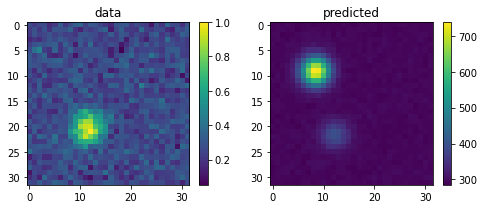

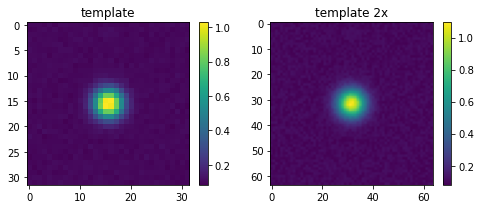

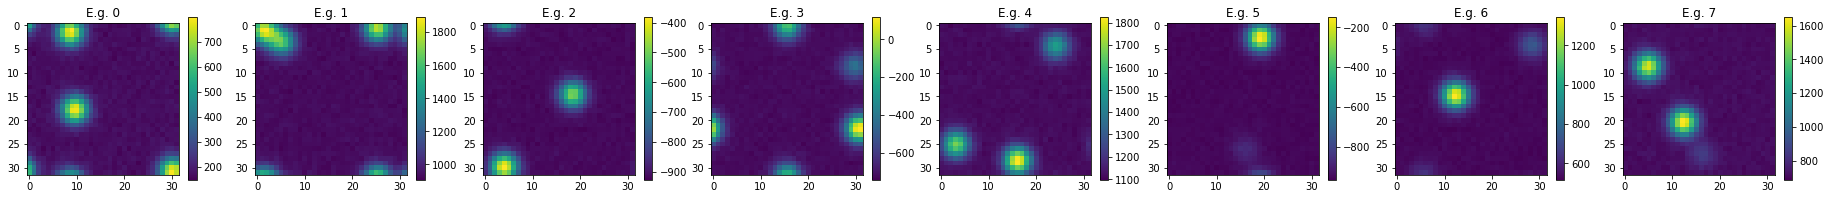

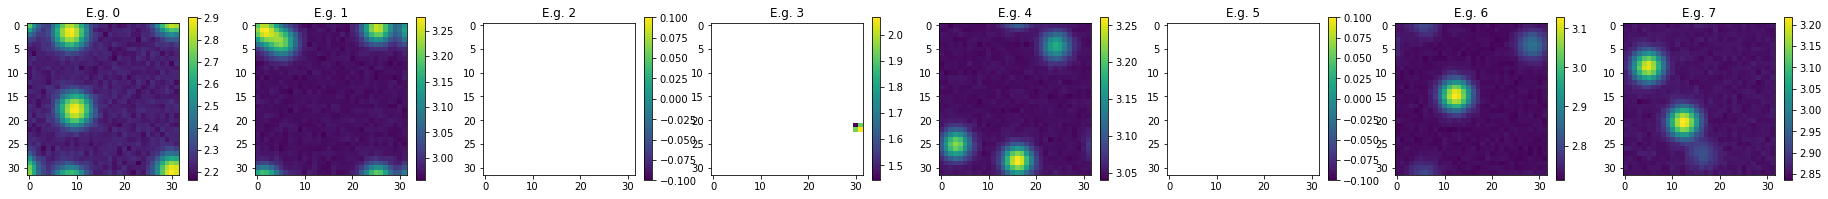

In [8]:
reload(model)


encoder_model = model.Template2DModel(fit_params=['x','y','A','bg',],
                                      max_psf_count=3,
                                      encoder_params={"depth":3, "first_layer_out_channels":16,},)
print(summary(encoder_model, input_size=(32, 1, 32, 32), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)

input shape: torch.Size([32, 1, 32, 32]), output_shape: (32, 1, 32, 32)


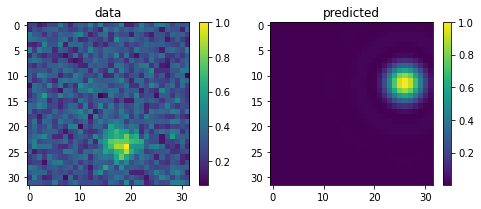

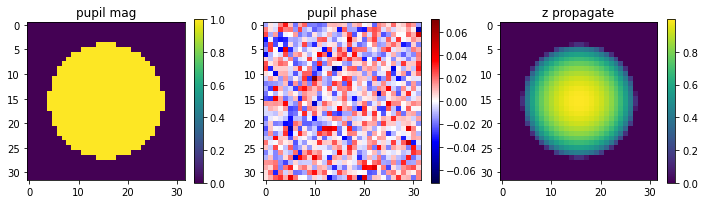

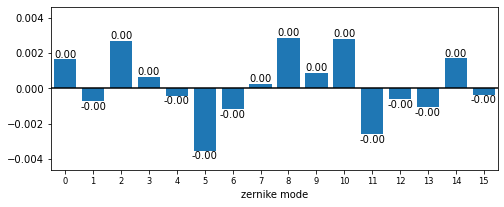

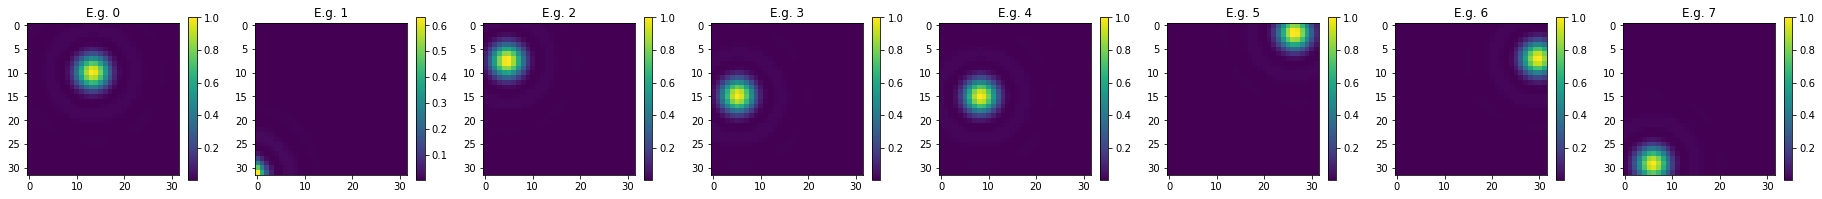

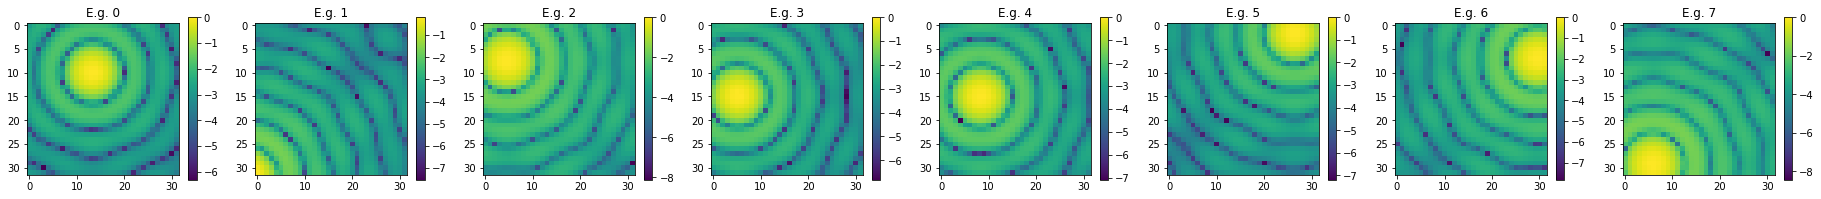

In [9]:
reload(model)

encoder_model = model.FourierOptics2DModel(fit_params=['x','y',],
                                           renderer_params={"pupil_params":{'scale':0.75, 'apod':False}},
                                           # normalize=False,
                                           encoder_params={"depth":3, "first_layer_out_channels":16,},
                                          )
# print(summary(encoder_model, input_size=(1024, 1, 32, 32), row_settings=["var_names"],))

model.check_model(encoder_model, train_dataloader)

Layer (type (var_name))                       Output Shape              Param #
FourierOptics2DModel                          --                        --
├─EncoderModel (encoder)                      [1024, 6, 1, 1]           --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [1024, 16, 16, 16]        --
│    │    │    └─GroupNorm (0)                [1024, 1, 32, 32]         2
│    │    │    └─Conv2d (1)                   [1024, 16, 32, 32]        160
│    │    │    └─ReLU (2)                     [1024, 16, 32, 32]        --
│    │    │    └─GroupNorm (3)                [1024, 16, 32, 32]        32
│    │    │    └─Conv2d (4)                   [1024, 16, 32, 32]        2,320
│    │    │    └─ReLU (5)                     [1024, 16, 32, 32]        --
│    │    │    └─MaxPool2d (6)                [1024, 16, 16, 16]        --
│    │    │    └─Dropout2d (7)                [1024, 16, 16, 16]        --
│    │    └─Seque

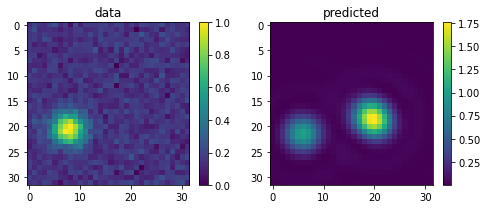

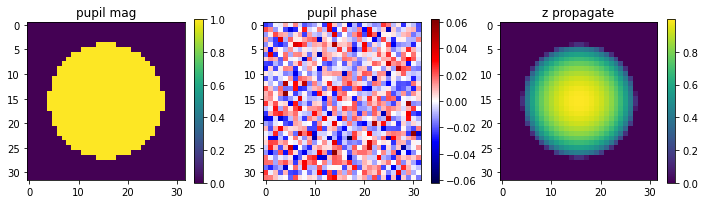

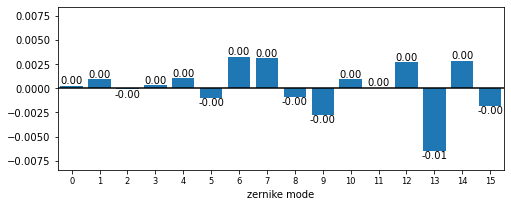

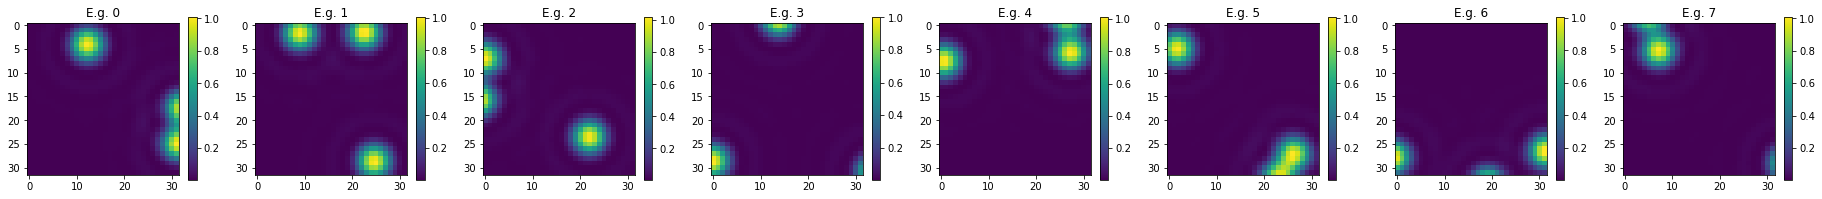

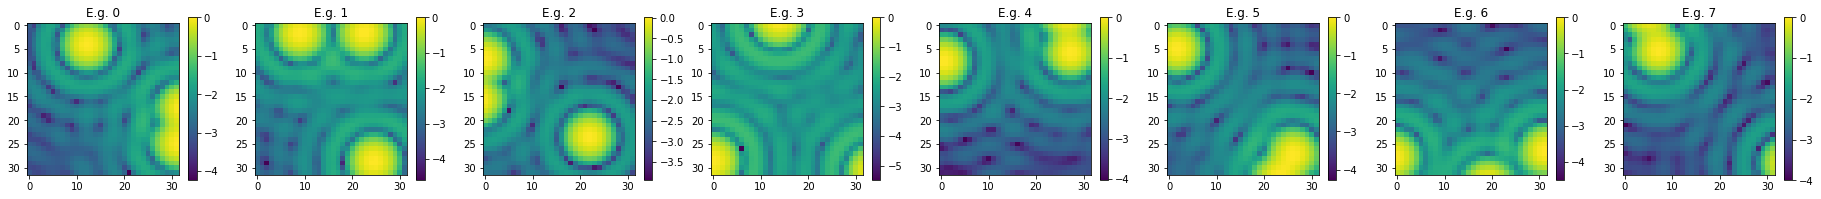

In [10]:
reload(model)

encoder_model = model.FourierOptics2DModel(fit_params=['x','y',], max_psf_count=3,
                                           encoder_params={"depth":3, "first_layer_out_channels":16,},)
print(summary(encoder_model, input_size=(1024, 1, 32, 32), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)

Layer (type (var_name))                       Output Shape              Param #
FourierOptics2DModel                          --                        --
├─EncoderModel (encoder)                      [1024, 5, 1, 1]           --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [1024, 16, 16, 16]        --
│    │    │    └─GroupNorm (0)                [1024, 1, 32, 32]         2
│    │    │    └─Conv2d (1)                   [1024, 16, 32, 32]        160
│    │    │    └─ReLU (2)                     [1024, 16, 32, 32]        --
│    │    │    └─GroupNorm (3)                [1024, 16, 32, 32]        32
│    │    │    └─Conv2d (4)                   [1024, 16, 32, 32]        2,320
│    │    │    └─ReLU (5)                     [1024, 16, 32, 32]        --
│    │    │    └─MaxPool2d (6)                [1024, 16, 16, 16]        --
│    │    │    └─Dropout2d (7)                [1024, 16, 16, 16]        --
│    │    └─Seque

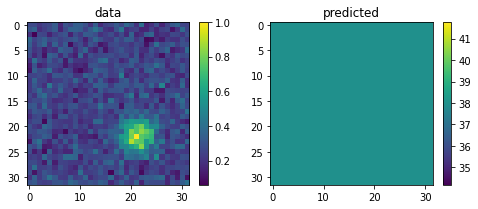

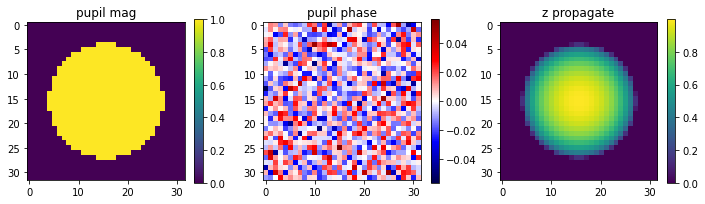

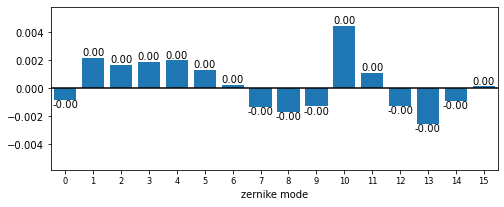

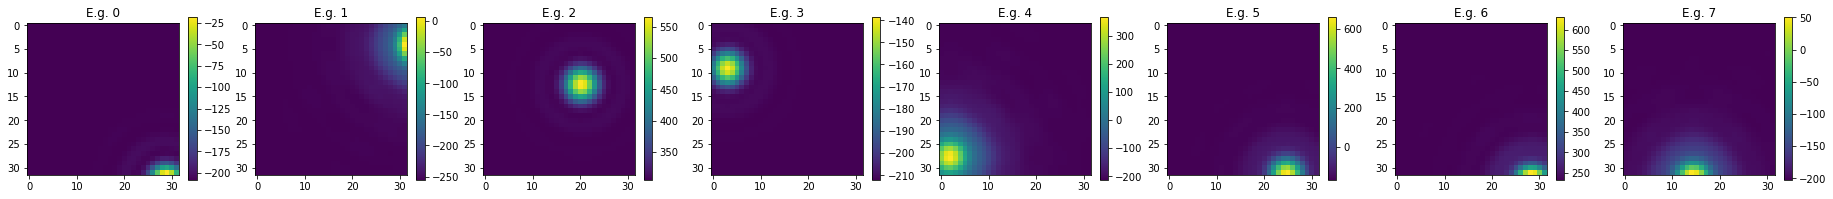

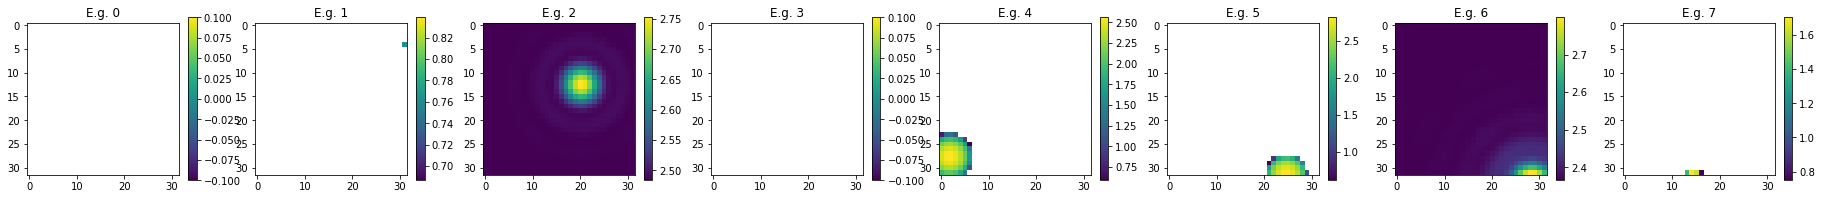

In [11]:
reload(model)

encoder_model = model.FourierOptics2DModel(fit_params=['x','y','z','bg','A'], max_psf_count=1,
                                           # normalize=False,
                                           encoder_params={"depth":3, "first_layer_out_channels":16,},)
print(summary(encoder_model, input_size=(1024, 1, 32, 32), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)


Layer (type (var_name))                       Output Shape              Param #
FourierOptics2DModel                          --                        --
├─FourierOptics2DRenderer (renderer)          --                        --
│    └─Sequential (pupil_phase)               [32, 32]                  --
│    │    └─ParameterModule (0)               [32, 32]                  1,024
│    │    └─Identity (1)                      [32, 32]                  --
│    │    └─Dropout (2)                       [32, 32]                  --
├─DirectConcatFeedbackModel (feedbacker)      [128, 4, 32, 32]          --
│    └─GroupNorm (norm)                       [128, 1, 32, 32]          2
├─EncoderModel (encoder)                      [128, 5, 1, 1]            --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [128, 16, 16, 16]         --
│    │    │    └─GroupNorm (0)                [128, 4, 32, 32]          8
│    │    │    └─Co

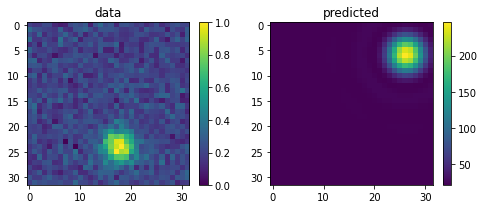

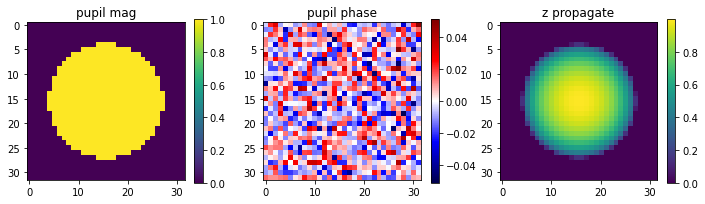

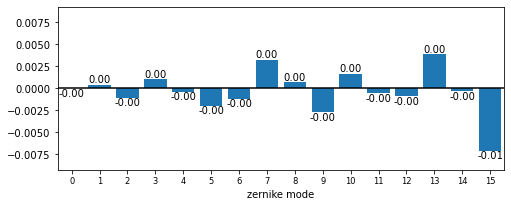

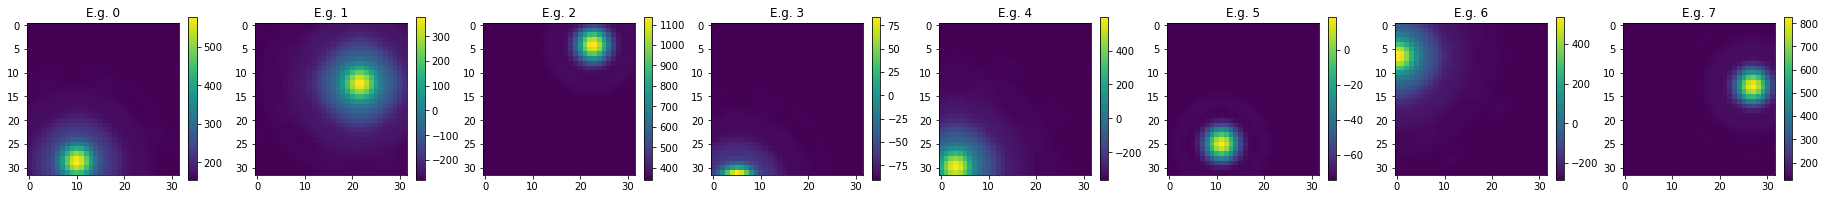

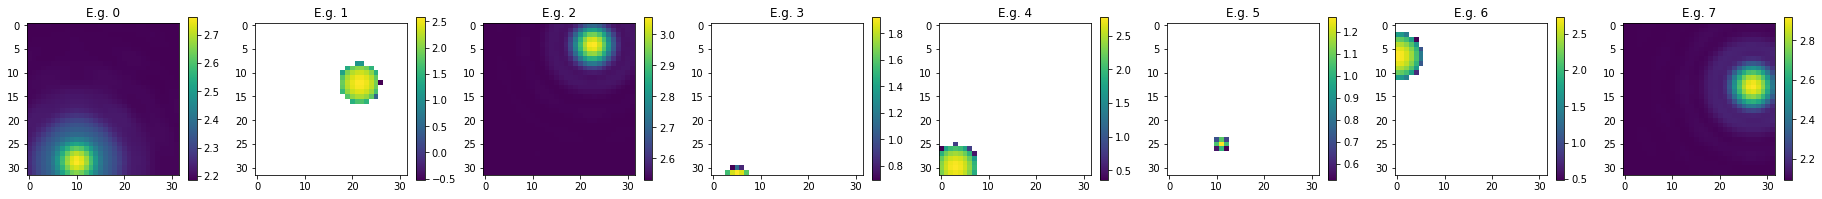

In [12]:
reload(model)

encoder_model = model.FourierOptics2DModel(feedback_class=model.DirectConcatFeedbackModel,
                                           fit_params=['x','y','z','bg','A'], max_psf_count=1,
                                           # normalize=False,
                                           encoder_params={"depth":3, "first_layer_out_channels":16,},)
print(summary(encoder_model, input_size=(128, 1, 32, 32), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)


Layer (type (var_name))                       Output Shape              Param #
FourierOptics2DModel                          --                        --
├─FourierOptics2DRenderer (renderer)          --                        --
│    └─Sequential (pupil_phase)               [32, 32]                  --
│    │    └─ParameterModule (0)               [32, 32]                  1,024
│    │    └─Identity (1)                      [32, 32]                  --
│    │    └─Dropout (2)                       [32, 32]                  --
├─DenseFeedbackModel (feedbacker)             [128, 4, 32, 32]          --
│    └─ModuleDict (feedback)                  --                        --
│    │    └─Sequential (dense_layer_0)        [1, 3, 32, 32]            --
│    │    │    └─GroupNorm (0)                [1, 3, 32, 32]            6
│    │    │    └─Linear (1)                   [1, 3, 32, 32]            1,056
│    │    │    └─ReLU (2)                     [1, 3, 32, 32]            --
│    │    │    

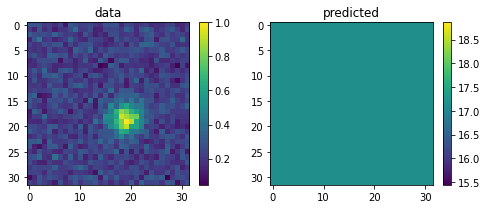

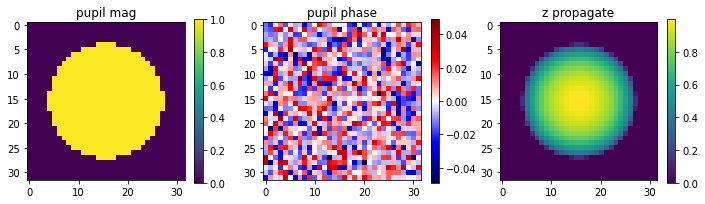

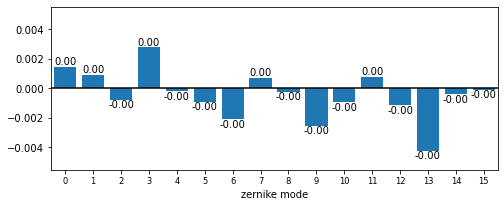

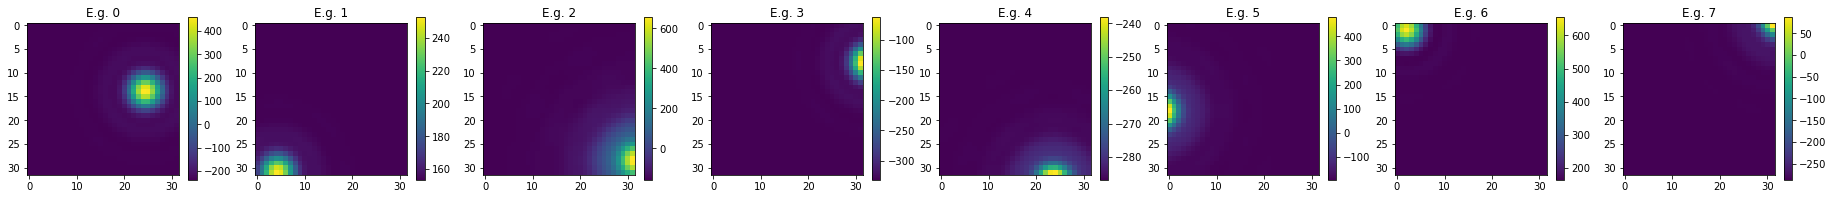

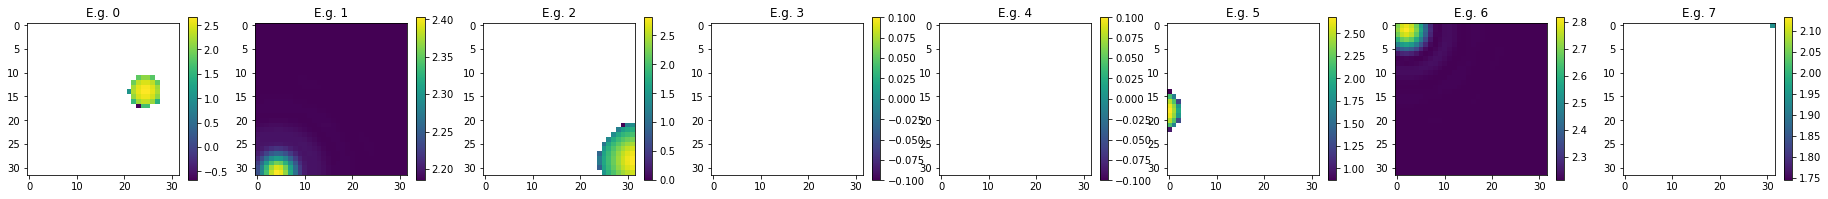

In [13]:
reload(model)

encoder_model = model.FourierOptics2DModel(feedback_class=model.DenseFeedbackModel,
                                           fit_params=['x','y','z','bg','A'], max_psf_count=1,
                                           # normalize=False,
                                           encoder_params={"depth":3, "first_layer_out_channels":16,},)
print(summary(encoder_model, input_size=(128, 1, 32, 32), row_settings=["var_names"], depth=4))

model.check_model(encoder_model, train_dataloader)


2:	 [x = -4.168,], [y = 0.423,],
6:	 [x = 0.858,], [y = 0.170,],
1:	 [x = 0.076,], [y = -3.704,],
3:	 [x = -2.140,], [y = -2.614,],
4:	 [x = 2.397,], [y = 3.027,],
7:	 [x = 1.579,], [y = 2.789,],
0:	 [x = 0.793,], [y = -4.161,],
5:	 [x = -1.344,], [y = 0.736,],


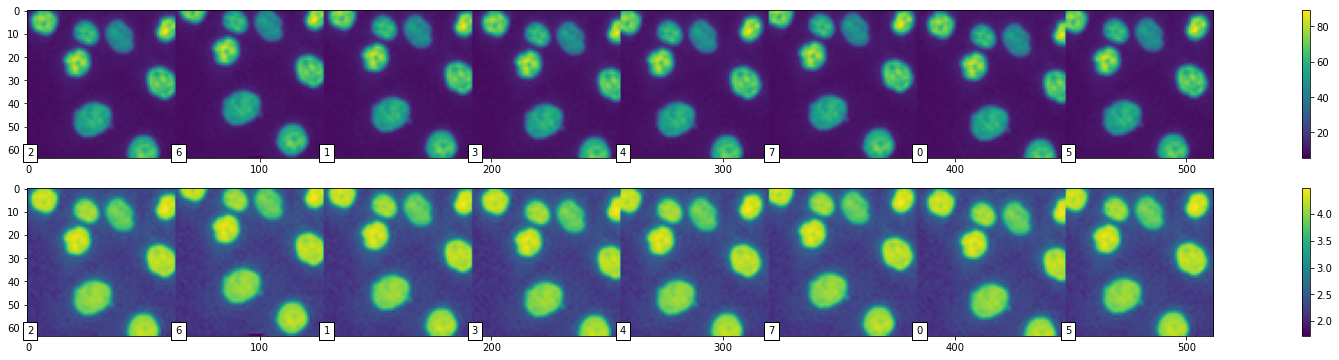

In [14]:
reload(dataset)
image_training_data = dataset.SingleImageDataset(skimage.data.human_mitosis()[20:, 20:],
                                                 out_size=(64,64),
                                                 template_padding=(8,8),
                                                 length=8, img_params={'shifts':[5, 5]},
                                                 noise_params={},
                                                 augmentations={},
                                                 normalize=False
                                                )
dataset.inspect_images(image_training_data)

train_image_dataloader = DataLoader(image_training_data,
                                    batch_size=32, shuffle=True)
# print(image_training_data[1][0].shape)

dd = next(iter(train_image_dataloader))
# print(dd[0].shape, dd[1])

input shape: torch.Size([8, 1, 64, 64]), output_shape: (8, 1, 64, 64)


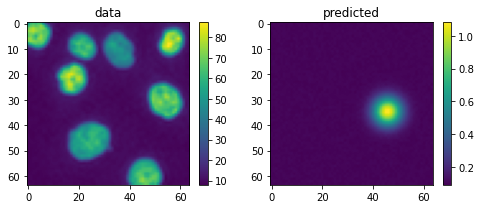

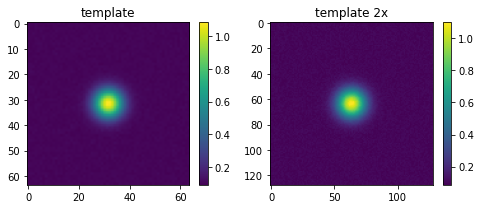

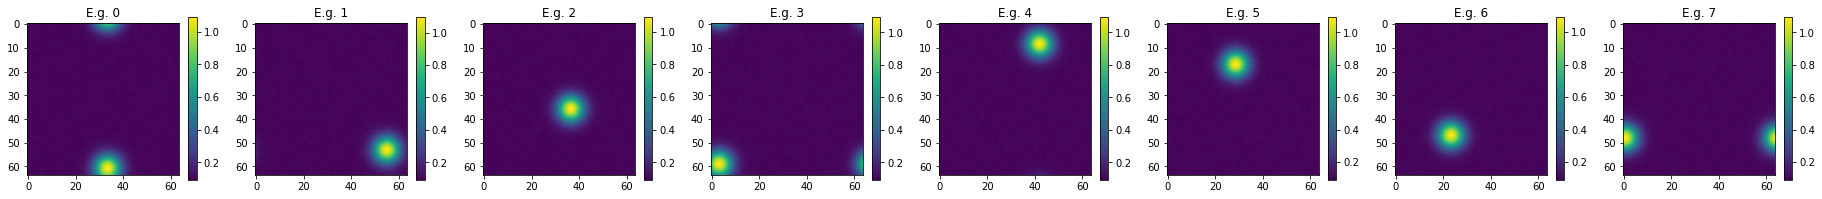

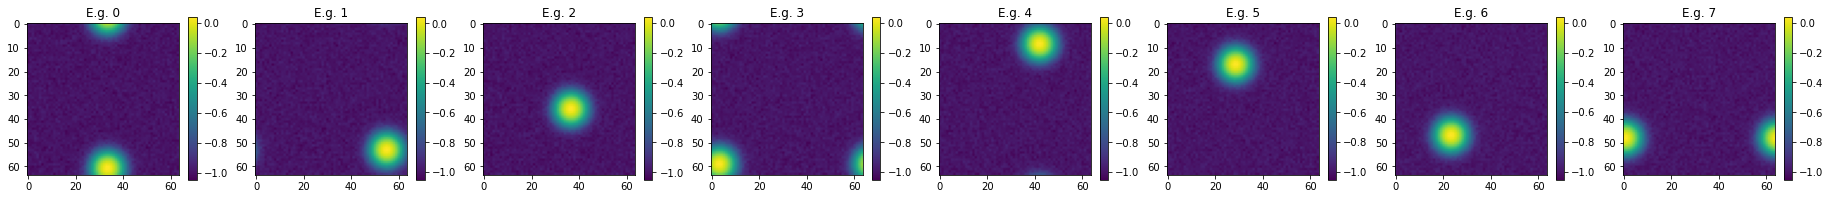

In [15]:
reload(model)

encoder_model = model.Template2DModel(img_size=(64,64),
                                      fit_params=['x','y'],
                                      # max_psf_count=3,
                                      encoder_params={"depth":3, "first_layer_out_channels":16,},)
# print(summary(encoder_model, input_size=(8, 1, 64, 64), row_settings=["var_names"],))

model.check_model(encoder_model, train_image_dataloader)

(1, 64, 64)
input shape: torch.Size([8, 1, 64, 64]), output_shape: (8, 1, 64, 64)


D:\Github\smlm-dl\smlm_dl\model.py:411: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if template_init is None or template_init == 'gauss':


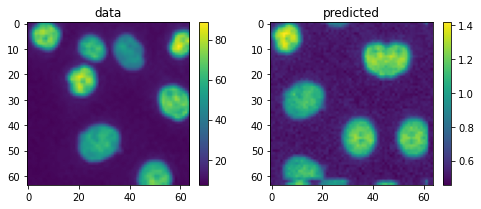

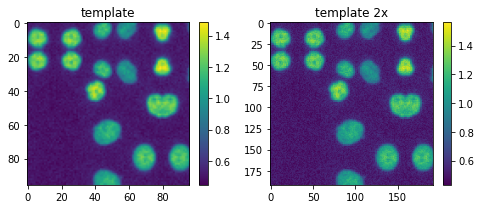

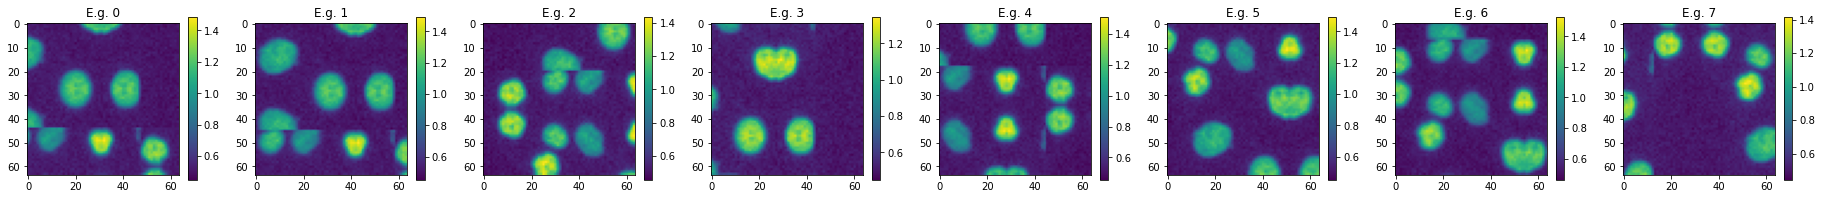

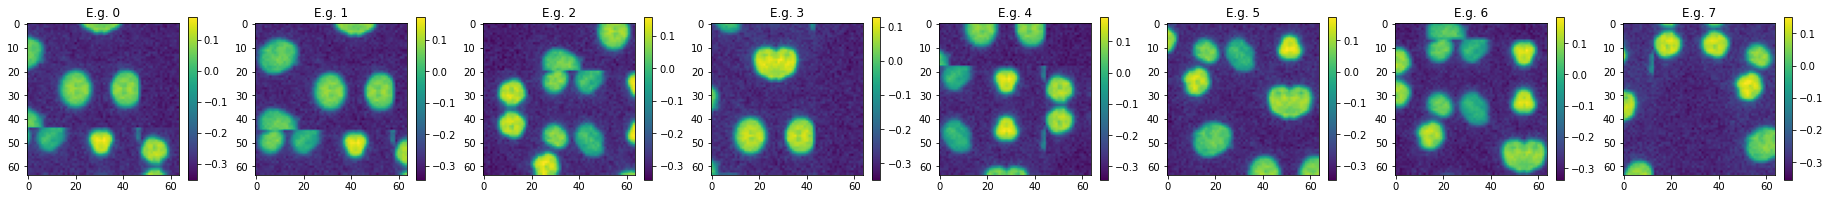

In [16]:
reload(model)
print(train_image_dataloader.dataset[0][0].shape)
encoder_model = model.Template2DModel(img_size=(64,64),
                                      fit_params=['x','y'],
                                      # max_psf_count=3,
                                      renderer_params={"template_init":train_image_dataloader.dataset[0][0].mean(0),
                                                       "template_padding":(16,16)},
                                      encoder_params={"depth":4, "first_layer_out_channels":16,},)
# print(summary(encoder_model, input_size=(8, 1, 64, 64), row_settings=["var_names"],))

model.check_model(encoder_model, train_image_dataloader)

(1, 64, 64)
input shape: torch.Size([8, 1, 64, 64]), output_shape: (8, 1, 64, 64)


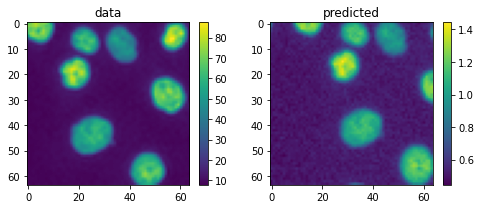

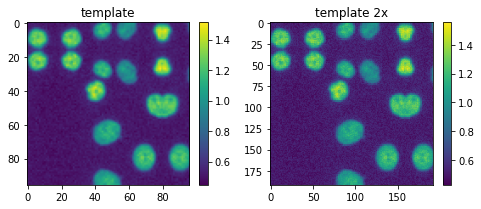

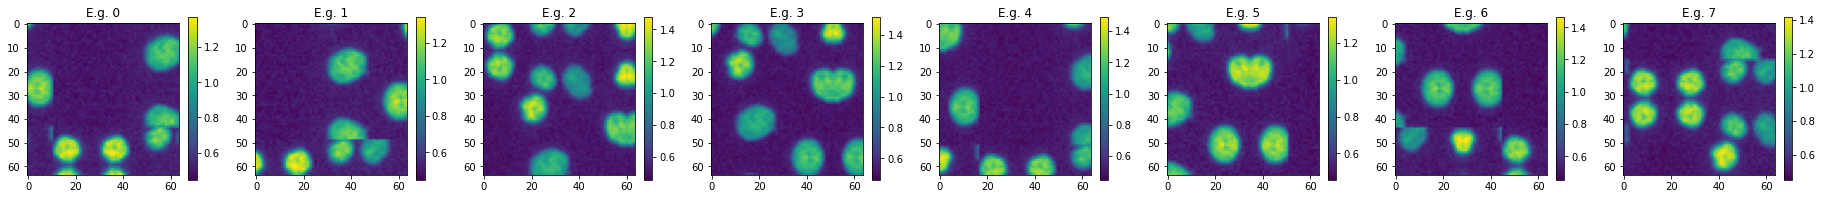

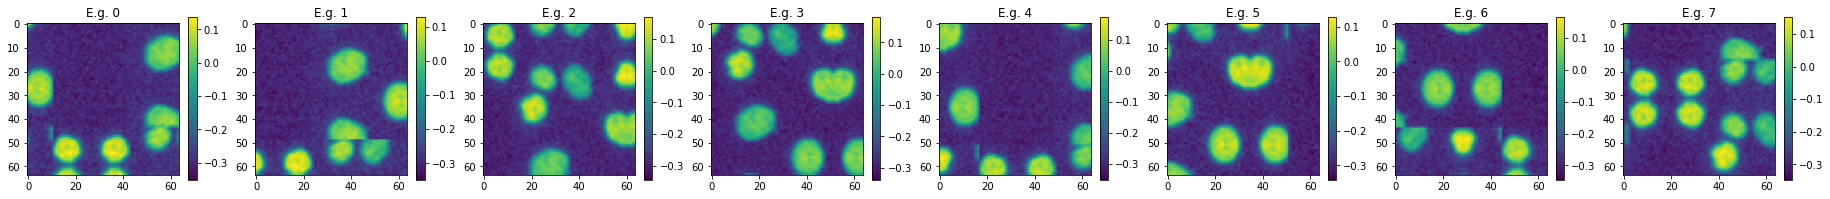

In [17]:
reload(model)
print(train_image_dataloader.dataset[0][0].shape)
encoder_model = model.Template2DModel(feedback_class=model.CropAndConcatFeedbackModel,
                                      img_size=(64,64),
                                      fit_params=['x','y'],
                                      # max_psf_count=3,
                                      renderer_params={"template_init":train_image_dataloader.dataset[0][0].mean(0),
                                                       "template_padding":(16,16)},
                                      encoder_params={"depth":4, "first_layer_out_channels":16,},)
# print(summary(encoder_model, input_size=(8, 1, 64, 64), row_settings=["var_names"],))

model.check_model(encoder_model, train_image_dataloader)